In [1]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st 
import resource
import seaborn as sns
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

import scipy.integrate as spi

sns.set_style("ticks")


In [2]:
#popparams

param_df=pd.read_csv('data/unadjusted_model_vl_popparms.csv')
aS,dS,lBt0,lp,dI,n,V0 = param_df['value'].iloc[1:8] #import population parameters

Bt0=10**lBt0; p=10**lp #unlog
g=23 #always true

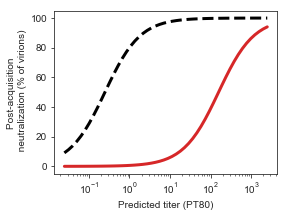

In [3]:
#post acquisition neutralization vs titer

hT=1 #for now
rho=10**2.8

xT=np.logspace(-1,4)
yT1=1/(1+xT**-hT)
yT2=1/(1+(xT/rho)**-hT)

T80=xT/4

plt.figure(figsize=(4,3))
plt.semilogx(T80,yT1*100,ls='--',label='in vitro',color='k',lw=3)
plt.semilogx(T80,yT2*100,label='in vivo PKPD-V',color='tab:red',lw=3)
plt.ylabel('Post-acquisition \n neutralization (% of virions)')
plt.xlabel('Predicted titer (PT80)')
#plt.legend(fontsize=12)
plt.savefig('figures/neut%.pdf')


In [29]:
#need to calculate extinction probability from the model
R0=2.1 #from bernoulli code

p_ext_model_vitro = 1/(R0*(1-yT1))
p_ext_model_vivo = 1/(R0*(1-yT2))

p_ext_model_vitro[p_ext_model_vitro>1]=1
p_ext_model_vivo[p_ext_model_vivo>1]=1

p_ext_placebo = 1/R0

#R0*(1-yT1)

(0, 1.1)

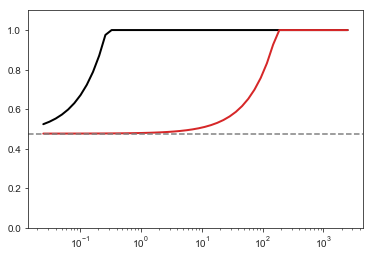

In [30]:
plt.semilogx(T80,p_ext_model_vitro,color='k',lw=2)
plt.semilogx(T80,p_ext_model_vivo,color='tab:red',lw=2)
plt.axhline(p_ext_placebo,ls='--',color='gray')
plt.ylim([0,1.1])


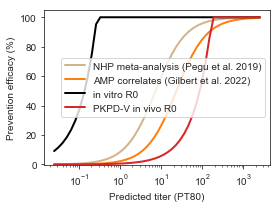

In [43]:
#pre-acquisition prevention efficacy vs titer

#post acquisition neutralization vs titer

hT=1 #for now
rho_NHP=91
rho_AMP=370

xT=np.logspace(-1,5)

PEnhp=1/(1+(xT/rho_NHP)**-hT)*100
PEamp=1/(1+(xT/rho_AMP)**-hT)*100

PEvitro=(1-((1-p_ext_model_vitro)/(1-p_ext_placebo)))*100
PEvivo=(1-((1-p_ext_model_vivo)/(1-p_ext_placebo)))*100

plt.figure(figsize=(4,3))
plt.semilogx(T80,PEnhp,ls='-',label='NHP meta-analysis (Pegu et al. 2019)',color='tan',lw=2)
plt.semilogx(T80,PEamp,label='AMP correlates (Gilbert et al. 2022)',color='tab:orange',lw=2)

plt.semilogx(T80,PEvitro,label='in vitro R0',color='k',lw=2)
plt.semilogx(T80,PEvivo,label='PKPD-V in vivo R0',color='tab:red',lw=2)
plt.ylabel('Prevention efficacy (%)')
plt.xlabel('Predicted titer (PT80)')
plt.ylim([-0.2,105])
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('figures/PE.pdf')


In [47]:
df=pd.read_csv('data/final_model_vl_summary.csv')



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


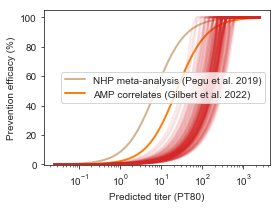

In [53]:
plt.figure(figsize=(4,3))
plt.semilogx(T80,PEnhp,ls='-',label='NHP meta-analysis (Pegu et al. 2019)',color='tan',lw=2)
plt.semilogx(T80,PEamp,label='AMP correlates (Gilbert et al. 2022)',color='tab:orange',lw=2)


for R0i in df['upslope_r0']:

    p_ext_model_vitro = 1/(R0i*(1-yT1))
    p_ext_model_vivo = 1/(R0i*(1-yT2))

    p_ext_model_vitro[p_ext_model_vitro>1]=1
    p_ext_model_vivo[p_ext_model_vivo>1]=1

    p_ext_placebo = 1/R0i
 
    PEvivo=(1-((1-p_ext_model_vivo)/(1-p_ext_placebo)))*100

    plt.semilogx(T80,PEvivo,color='tab:red',lw=2,alpha=0.1)
    
plt.ylabel('Prevention efficacy (%)')
plt.xlabel('Predicted titer (PT80)')
plt.ylim([-0.2,105])
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('figures/PEi.pdf')

#R0*(1-yT1)

In [52]:
#PKPD model

#calculate Ab model at any time (note dosing interval mod)
def ab_sim(t,Y1,Y2,IC50,h,rho):
    Y_t = Y1*np.exp(-k1*t)+Y2*np.exp(-k2*t) #VRC01 concentration
    nu_t = 1/(1+(rho*IC50/Y_t)**h) #neutralization [0-1], with potency reduction
    return Y_t,nu_t

#calculate Ab model at any time (note dosing interval mod)
def nu_sim(t,T0,kT,h):
    T = T0*np.exp(-kT*t) #titer over time
    nu_t = 1/(1+T**-h) #neutralization [0-1], with potency reduction
    return T_t,nu_t

In [53]:
#viral model

def ode_sim(X,t,aS,dS,Bt0,dI,n,p,g,Y1,Y2,IC50,h,rho,doseoffset):
    dY = np.zeros(3);
    S=X[0]; P=X[1]; V=X[2];
    
    tAb=t+doseoffset #how many days relative to infection was last infusion
    
    Y_t,nu_t = ab_sim(tAb,Y1,Y2,IC50,h,rho)
        
    dY[0] = aS - dS*S - (1-nu_t)*Bt0*S*V     #susceptible cells [cells/uL]
    dY[1] = (1-nu_t)*Bt0*S*V - dI*P*P**n     #productively infected cells [cells/uL]
    dY[2] = p*P - g*V - Bt0*S*V              #productive virus [virus/uL]

    return dY

#viral model

def ode_sim2(X,t,aS,dS,Bt0,dI,n,p,g,T0,kT,h,doseoffset):
    dY = np.zeros(3);
    S=X[0]; P=X[1]; V=X[2];
    
    tAb=t+doseoffset #how many days relative to infection was last infusion
    
    T_t,nu_t = nu_sim(t,T0,kT,h)
        
    dY[0] = aS - dS*S - (1-nu_t)*Bt0*S*V     #susceptible cells [cells/uL]
    dY[1] = (1-nu_t)*Bt0*S*V - dI*P*P**n     #productively infected cells [cells/uL]
    dY[2] = p*P - g*V - Bt0*S*V              #productive virus [virus/uL]

    return dY



NameError: name 'IC80' is not defined

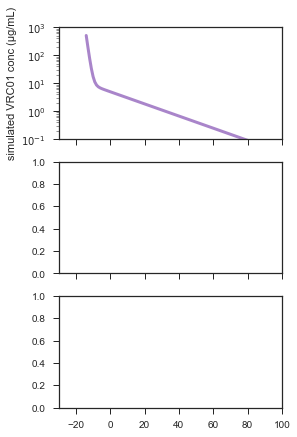

In [54]:
#make all pkpd plots (or some examples or whatever)

simt=np.arange(100) #first 100 days

Y1=500; Y2=10; #initial concentrations ug/mL
k1=1; k2=0.05 #decay rates (per day)
IC50=0.1
h=1
rho=100
#IC80=

doseoffset=14

sol=spi.odeint(ode_sim, [aS/dS,V0/p*g,V0], simt, (aS,dS,Bt0,dI,n,p,g,Y1,Y2,IC50,h,rho,doseoffset), rtol=1e-12) 
vv=sol[:,2]
extinguish=0
if (vv<V0/10).any():
    vext = np.where(vv<V0/10)[0][0]
    extinguish=1
    vv[vext:]=1e-6

simV=np.log10(vv*1e3) #viral load as usual units copies/mL

tAb=simt-doseoffset #how many days relative to infection was last infusion
Y_t,nu_t = ab_sim(simt,Y1,Y2,IC50,h,rho)

fig,axs=plt.subplots(3,1,sharex=True,figsize=(4,7))

axs[0].semilogy(tAb,Y_t,marker='',ls='-',alpha=0.8,color='tab:purple',lw=3)
axs[0].set_ylabel('simulated VRC01 conc (µg/mL)')
axs[0].set_ylim([0.1,1e3])
axs[0].set_yticks([0.1,1,10,100,1e3])
axs[0].set_xlim([-30,100])

axs[1].plot(tAb,Y_t/IC80,marker='',ls='-',alpha=0.8,color='tab:purple',lw=3)
axs[1].set_ylabel('Predicted titer (PT80)')
#axs[1].axvline(0)

#axs[1].plot(tAb,nu_t*100,marker='',ls='-',alpha=0.8,color='tab:purple',lw=3)
#axs[1].set_ylabel('neutralization (%)')
#axs[1].set_ylim([-5,105])

axs[1].axvline(0,color='gray',alpha=0.5)
#axs[1].axhline(nu_t[np.where(tAb==0)[0][0]]*100,color='gray',alpha=0.5)

axs[2].plot(simt,simV,marker='',ls='-',alpha=1,lw=3,color='k')
if extinguish==1:
    plt.annotate('extinguished',[0,2])
axs[2].set_ylim([1,8])
axs[2].set_ylabel('Viral load log10(copies/mL)')
axs[2].set_xlabel('Time (days relative to exposure)')

plt.tight_layout()


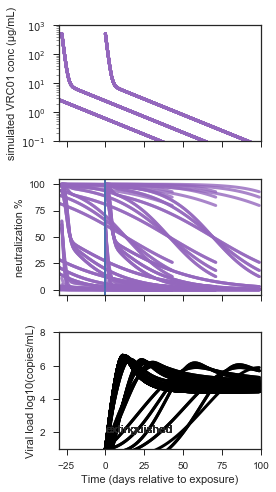

In [55]:
#do a big loop

N1=3
N2=3
N3=3
N4=3

outl=[]

fig,axs=plt.subplots(3,1,sharex=True,figsize=(4,7))
for IC50 in np.logspace(-2,1,N1):
    for h in np.linspace(0.7,1.3,N2):
        for doseoffset in np.linspace(0,8*7,N3):
            for phi in np.logspace(0,3,N4):

                sol=spi.odeint(ode_sim, [aS/dS,V0/p*g,V0], simt, (aS,dS,Bt0,dI,n,p,g,Y1,Y2,IC50,h,phi,doseoffset), rtol=1e-12) 
                vv=sol[:,2]
                extinguish=0
                if (vv<V0/10).any():
                    vext = np.where(vv<V0/10)[0][0]
                    extinguish=1
                    vv[vext:]=1e-6

                simV=np.log10(vv*1e3) #viral load as usual units copies/mL

                tAb=simt-doseoffset #how many days relative to infection was last infusion
                Y_t,nu_t = ab_sim(simt,Y1,Y2,IC50,h,phi)


                axs[0].semilogy(tAb,Y_t,marker='',ls='-',alpha=0.8,color='tab:purple',lw=3)
                axs[0].set_ylabel('simulated VRC01 conc (µg/mL)')
                axs[0].set_ylim([0.1,1e3])
                axs[0].set_yticks([0.1,1,10,100,1e3])
                axs[0].set_xlim([-30,100])

                axs[1].plot(tAb,nu_t*100,marker='',ls='-',alpha=0.8,color='tab:purple',lw=3)
                axs[1].set_ylabel('neutralization %')
                axs[1].set_ylim([-5,105])
                axs[1].axvline(0)

                #axs[1].plot(tAb,nu_t*100,marker='',ls='-',alpha=0.8,color='tab:purple',lw=3)
                #axs[1].set_ylabel('neutralization (%)')
                #axs[1].set_ylim([-5,105])
                #axs[1].axvline(0)

                axs[2].plot(simt,simV,marker='',ls='-',alpha=1,lw=3,color='k')
                if extinguish==1:
                    plt.annotate('extinguished',[0,2])
                axs[2].set_ylim([1,8])
                axs[2].set_ylabel('Viral load log10(copies/mL)')
                axs[2].set_xlabel('Time (days relative to exposure)')

                plt.tight_layout()

                outl.append([IC50,h,doseoffset,phi,extinguish,nu_t[np.where(tAb==0)[0][0]]*100,np.max(simV)])


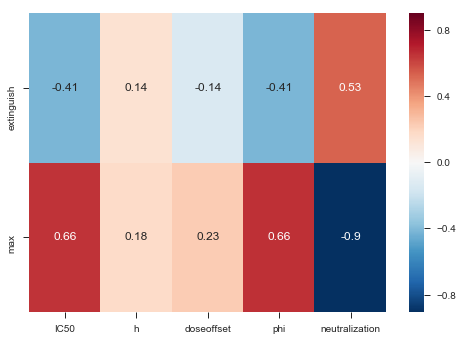

In [19]:
outdf = pd.DataFrame(outl,columns=['IC50','h','doseoffset','phi','extinguish','neutralization','max'])

corrdf=outdf.corr(method='spearman')

sns.heatmap(corrdf.loc[['extinguish','max'],['IC50','h','doseoffset','phi','neutralization']],annot=True)

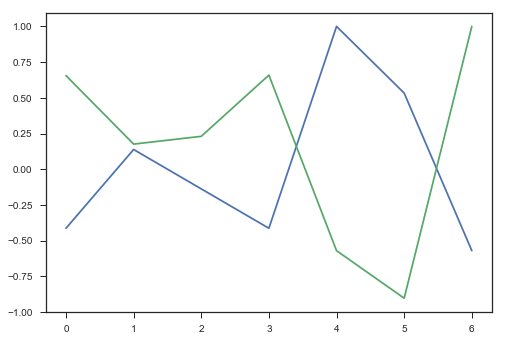

In [15]:
plt.plot(np.arange(7),corrdf['extinguish'])
plt.plot(np.arange(7),corrdf['max'])
